In [1]:
## Tsquare

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
"""
Created on Wed Jul  6 14:29:39 2022
@author: suhong

Revised on Thur Jul  13 15:00:39 2022
@author: Junhyun

"""

import numpy as np
import pandas as pd
import joblib

def bootstrap_limit(stat, alpha=0.05, bootstrap=100):
    '''
        @Description
            Bootstrap sampling을 활용한 Control Limit 산출 기법

        @Parameter
            stat : 통계량 (정상상태의 데이터 입력)
            alpha : Control Limit을 정하기 위한 유의수준 (0~1)
            bootstrap : 샘플링 횟수
        @Return
            limit : 임계값 (CL : Control Limit)
    '''
    alpha = alpha*100
    alpha = 100 - alpha
    samsize = max(100, len(stat))
    
    stat = stat.reshape(len(stat)) # 2차원 array를 1차원 array로 변환
    
    # bootstrap 수 만큼 다음 작업을 반복 : samsize(최소 10000번)만큼 정상상태 데이터를 유의수준 만큼 복원 추출 후 평균 값 사용 
    limit = np.mean(list(map(lambda x:np.percentile(np.random.choice(stat,samsize,replace=True),alpha), range(0,bootstrap))))
    
    return limit

# import Hotellings_tsquare

class Hotellings_tsquare ():
    
    """
    Hotellings T square
    """
    
    def __init__(self) :
        
        self.tr_mu = None
        self.tr_cov = None
        self.cl = None
        
    def fit(self, trdat, alpha = 0.05) :
        """

        Parameters
        ----------
        trdat : array
            Train data
        alpha : int, 0~1
            Bootstrap Limit value. The default is 0.05.

        Returns
        -------
        trScore : array
            Train Score, 이상치 점수를 의미함. 클수록 정상패턴에서 벗어남을 의미
        CL : float
            trScore Control Limit

        """
        if isinstance(trdat,(np.ndarray)):
            trdat = pd.DataFrame(trdat)
            
        trScore = np.zeros((trdat.shape[0], 1))
        self.tr_mu = trdat.mean(axis = 0)
        self.tr_cov = trdat.cov()
        for i in range(len(trdat)):
            trScore[i] = (trdat.values[i] - self.tr_mu) @ np.linalg.pinv(self.tr_cov) @ (trdat.values[i] - self.tr_mu).transpose()
        
        self.cl = bootstrap_limit(trScore, alpha=alpha, bootstrap=100)
        
        return {'trScore' : trScore}
    
    def CL_printor(self) :
        """
        
        Returns
        -------
        CL: float
            Control Limit,
            
        """
        
        return {'CL' : self.cl}
    
    def predict(self, tsdat) :
        """

        Parameters
        ----------
        tsdat : array
            Test data. 예측 대상이 되는 데이터

        Returns
        -------
        tsScore : array
            Test data의 이상치 값

        """
        if isinstance(tsdat,(np.ndarray)):
            tsdat = pd.DataFrame(tsdat)
            
        tsScore = np.zeros((tsdat.shape[0], 1))
        
        for i in range(len(tsdat)):
            tsScore[i] = (tsdat.values[i] - self.tr_mu) @ np.linalg.pinv(self.tr_cov) @ (tsdat.values[i] - self.tr_mu).transpose()
            
        return {'tsScore' : tsScore}

In [4]:
def tsquare(trdat, tsdat, alpha=0.05):
    """

    Parameters
    ----------
    trdat : array
        Train data. 학습 대상이 되는 데이터
    tsdat : array
        Test data. 예측 대상이 되는 데이터
    alpha : float, 0~1
            Bootstrap Limit value. The default is 0.05.

    Returns
    -------
    trScore : array
        Train data의 이상치 값
    tsScore : array
        Test data의 이상치 값
    CL : float 
        Control Limit

    """
    model = Hotellings_tsquare()
    fit = model.fit(trdat, alpha=alpha)
    CL = model.CL_printor()
    pred = model.predict(tsdat)
    
    # tsquare model pickle 파일로 저장
    # saved_model = joblib.dump(model, 't2.pkl')
    
    return {'trScore':fit['trScore'], 'tsScore':pred['tsScore'], 'CL': CL['CL']}
        

In [5]:
df = pd.read_csv('./data/shot6_3D365-48910.csv', encoding='euc-kr')

In [64]:
labels = df['판정코드']

In [65]:
labels.value_counts()

0    6885
1       8
Name: 판정코드, dtype: int64

In [68]:
# train 정상, test 정상
in_train, in_test = train_test_split(df.loc[labels == 0], test_size=0.3, shuffle=False)

In [70]:
# test 이상
out_test = df[labels == 1]

# test
test = pd.concat([in_test, out_test], axis=0)

In [74]:
test['판정코드'].value_counts()

0    2066
1       8
Name: 판정코드, dtype: int64

In [76]:
model = tsquare(in_train.iloc[:,2:], test.iloc[:,2:], alpha=0.05)

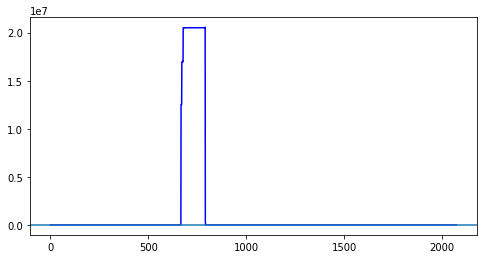

In [95]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(model['tsScore'], color='blue')
plt.axhline(y = model['CL'])
plt.show()

In [48]:
# index : 0~32 실제 값
# index : 33~ 세팅 값